In [1]:
import os
import sys
import datetime

In [2]:
sys.path.append(os.path.join(os.pardir, 'src'))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow as tf

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
from tqdm.auto import tqdm
from collections import defaultdict

In [6]:
from CBO.distributions import Normal, NumpyNormal
from CBO.functions import rastrigin, rastrigin_c, square
from CBO.minimize import minimize
from CBO.visualizations import visualize_trajectory_convergence
from CBO.train import train, NeuralNetworkObjectiveFunction, TensorboardLogging, compute_model_dimensionality, UpdatableTfModel

In [7]:
def load_mnist_data():
    (X_train, y_train),(X_test, y_test) = mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = load_mnist_data()

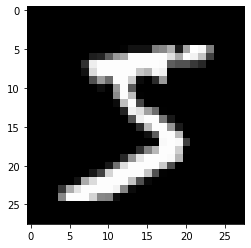

In [9]:
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))

In [10]:
class ShallowNN:
    def __init__(self, target_shape=10, eps=1e-5):
        self.target_shape = target_shape
        self.W = None
        self.b = None
        self.eps = eps
        
    def init(self, X):
        X = tf.reshape(X, (X.shape[0], -1))
        self.W = tf.convert_to_tensor(np.random.normal(0, 1, (X.shape[1], self.target_shape)))
        self.b = tf.convert_to_tensor(np.random.normal(0, 1, self.target_shape))
        X_prime = X @ self.W + self.b
        X_prime = tf.nn.relu(X_prime)
        self.mean = tf.reshape(tf.reduce_mean(X_prime, axis=1), (-1, 1))
        self.std = tf.reshape(tf.math.reduce_std(X_prime, axis=1), (-1, 1))
        # print(self.mean, self.std)
    
    def set_weights(self, weights):
        weights = tf.reshape(weights, -1)
        expected_W_shape = tf.reshape(self.W, -1).shape[0]
        expected_shape = expected_W_shape + tf.reshape(self.b, -1).shape[0]
        if expected_shape != weights.shape[0]:
            return RuntimeError(f'Provided tensor shape does not coincide with the expected: {exected_shape} != {weights.shape[0]}')
        self.W = tf.reshape(weights[:expected_W_shape], self.W.shape)
        self.b = tf.reshape(weights[expected_W_shape:], self.b.shape)
        
    def get_weights(self):
        return tf.concat([tf.reshape(w, -1) for w in [self.W, self.b]], axis=0)
    
    def __call__(self, X):
        X = tf.reshape(X, (X.shape[0], -1))
        if self.W is None:
            raise RuntimeError('Weights of the network aren\'t initialized, call SmallNet.init')
        Z = X @ self.W + self.b
        Z = tf.nn.relu(Z)
        Z = (Z - self.mean) / (self.std + self.eps)
        return tf.nn.softmax(Z)

In [11]:
model = ShallowNN()
model.init(X_train)

In [12]:
class MmistObjective:
    def __init__(self, target_shape=10):
        self.target_shape = target_shape
        self.model = ShallowNN(target_shape=target_shape)
        self.loss = tf.keras.losses.CategoricalCrossentropy()
        self.X = None
        self.y = None
        
    def set_dataset(self, X, y):
        self.model.init(X)
        self.X = X
        self.y = tf.one_hot(y, self.target_shape)
    
    def __call__(self, weights):
        self.model.set_weights(weights)
        return self.loss(self.y, self.model(self.X))
    
    def predict(self):
        return self.model(self.X)

In [13]:
# for _ in range(100):
objective = MmistObjective()
objective.set_dataset(X_train[:1000], y_train[:1000])
# print(objective(objective.model.get_weights()))

In [14]:
minimizer, trajectory = minimize(objective, dimensionality=model.get_weights().shape[0], n_particles=100, 
                                 time_horizon=8, 
                                 return_trajectory=True, optimizer_config = {
                                     'alpha': 50,
                                     'sigma': 0.4**0.5,
                                     'dt': 0.1,
                                 },
                                 n_batches=10,
                                 initial_distribution=NumpyNormal())

100%|██████████| 81/81 [08:55<00:00,  6.61s/it]


In [15]:
objective(minimizer)

<tf.Tensor: shape=(), dtype=float64, numpy=2.3347246646881104>

In [16]:
predictions = tf.math.argmax(objective.predict(), axis=1)[:1000]

In [17]:
np.sum(predictions==y_train[:1000])

108

In [18]:
tf.math.confusion_matrix(y_train[:1000], predictions)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[  8,   0,  70,   3,   0,   9,   0,   1,   0,   6],
       [  4,   7,  96,   0,   0,   0,   0,   8,   0,   1],
       [  2,   0,  78,   0,   0,  12,   0,   2,   0,   5],
       [  6,   0,  83,   0,   0,   2,   0,   0,   0,   2],
       [  2,   0, 102,   0,   0,   0,   0,   0,   0,   1],
       [ 17,   0,  61,   1,   0,   4,   0,   7,   0,   2],
       [  0,   0,  92,   0,   0,   0,   0,   1,   0,   1],
       [ 38,   4,  41,   3,   0,  16,   0,   3,   0,  12],
       [  2,   0,  78,   1,   0,   0,   0,   4,   0,   2],
       [  3,   1,  71,   2,   0,   3,   0,  12,   0,   8]], dtype=int32)>